# OFDM Get Ber from SNR

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
#######################TRANSMISSION CARACTERISTICS##########################

K = 128 # number of OFDM subcarriers
CP = 16  # length of the cyclic prefix: 25% of the block
#pilotValue = 3+3j # The known value each pilot transmits

allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])


# data carriers are all remaining carriers
dataCarriers = allCarriers

mu = 2 # bits per symbol (i.e. 4QAM)
payloadBits_per_OFDM = K*mu  # number of payload bits per OFDM symbol

In [14]:
mapping_table = {
    (1,1) : -1-1j,
    (1,0) : -1+1j,
    (0,1) :  1-1j,
    (0,0) :  1+1j
}
demapping_table = {v : k for k, v in mapping_table.items()}

In [15]:
#Change from serial to paralel
def SP(bits):
    return bits.reshape((len(dataCarriers), mu))


def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])

#IDFT using sqrt ! important
def IDFT(OFDM_data):
    return np.sqrt(len(OFDM_data))*np.fft.ifft(OFDM_data)

#Add the CP 
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]  
    return np.hstack([cp, OFDM_time]) 


def awgn(TX, var):
    num=len(TX)
    noisei = np.random.normal(0,np.sqrt(var),num)
    noisej = 1j*np.random.normal(0,np.sqrt(var),num)
    RX = TX[:]+noisei[:]+noisej[:]
    return RX


def removeCP(signal):
    return signal[CP:(CP+K)]

#DFT according to idft
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)/ np.sqrt(len(OFDM_RX))


def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision


def PS(bits):
    return bits.reshape((-1,))

In [16]:
from scipy.special import erfc, erfcinv

In [17]:
import copy 
def getber(esno):
    K = 128
    nbits = 256
    inbits = np.random.binomial(n=1, p=0.5, size=(nbits, )) #Create random bits
    bits = copy.deepcopy(inbits)
    

    var=esno
    
    bits = SP(bits)
    bits = Mapping(bits)
    bits = IDFT(bits)
    bits = addCP(bits)
    bits = awgn(bits, var)
    bits = removeCP(bits)
    bits = DFT(bits)
    bits, hardDecision = Demapping(bits)
    bits = PS(bits)
    BER = np.sum(abs(bits-inbits))/len(bits)
    return BER
    print(BER)


results = []
for i in range(1,11):
    
    sigs =  2 #Sigmasquare of signal
    ESNO = 10**(i/10)
    var=sigs/(ESNO*2)
    var = var * (144/128)
    niter = 1000
    bers=np.zeros(niter)
    
    for j in range(niter): #Do 1000 experiments
        bers[j] = getber(var)
    a=np.average(bers)
    print('es/no = {}dB -- Average over {} symbols with variance: {:.2f} is {}'.format(i,niter,var,a))
    results.append(a)




es/no = 1dB -- Average over 1000 symbols with variance: 0.89 is 0.14434375
es/no = 2dB -- Average over 1000 symbols with variance: 0.71 is 0.11670703125
es/no = 3dB -- Average over 1000 symbols with variance: 0.56 is 0.09130078125
es/no = 4dB -- Average over 1000 symbols with variance: 0.45 is 0.067421875
es/no = 5dB -- Average over 1000 symbols with variance: 0.36 is 0.04697265625
es/no = 6dB -- Average over 1000 symbols with variance: 0.28 is 0.030015625
es/no = 7dB -- Average over 1000 symbols with variance: 0.22 is 0.0176328125
es/no = 8dB -- Average over 1000 symbols with variance: 0.18 is 0.00882421875
es/no = 9dB -- Average over 1000 symbols with variance: 0.14 is 0.00405859375
es/no = 10dB -- Average over 1000 symbols with variance: 0.11 is 0.0013046875


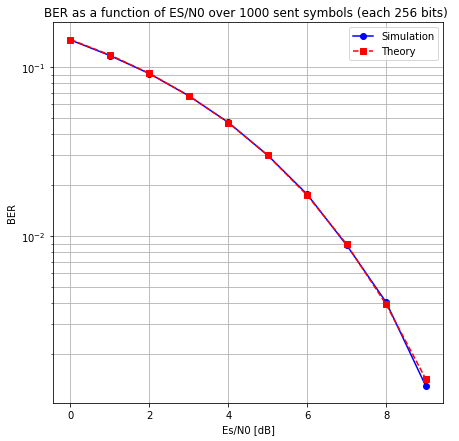

In [18]:
plt.figure(figsize = (7,7))
plt.plot(results, '-bo')
plt.yscale("log")


esno = np.arange(1,11)
esno = 10**(esno/10)
SNR = esno/(144/128)
theroy= (1/2)*erfc(np.sqrt(SNR/2))
plt.plot(theroy, '--rs')
plt.legend(['Simulation', 'Theory'])
plt.xlabel("Es/N0 [dB]")
plt.ylabel("BER")
plt.grid(True, which="both")
plt.title("BER as a function of ES/N0 over 1000 sent symbols (each 256 bits) ")
plt.savefig("Images_OFDM/beresno.png")
plt.show()

# Old simulations, not correct 

In [8]:
def bervar(Subcarriers, CP, bps, esno):   
    K = Subcarriers
    payloadBits_per_OFDM = K*bps #Subcarriers * bits per symbol
    bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, )) #Create random bits
    N = payloadBits_per_OFDM
    
    sigs =  2 #Sigmasquare of signal
    var = (sigs * (N+CP))/( 2*esno*N) #Variance as function of esno 
    var = var/2 #Devide by 2 because we're on the complex plane
   # print(var)
    
    bits_SP = SP(bits)
    QAM = Mapping(bits_SP)
    #OFDM_data = OFDM_symbol(QAM)
    OFDM_time = IDFT(QAM)
    OFDM_withCP = addCP(OFDM_time)
    OFDM_TX = OFDM_withCP
    OFDM_RX = awgn(OFDM_TX,var) #Applies AWGN to each element with a given variance
    OFDM_RX_noCP = removeCP(OFDM_RX) 
    OFDM_demod = DFT(OFDM_RX_noCP)
    PS_est, hardDecision = Demapping(OFDM_demod)
    bits_est = PS(PS_est)
    BER = np.sum(abs(bits-bits_est))/len(bits)

    return BER
    


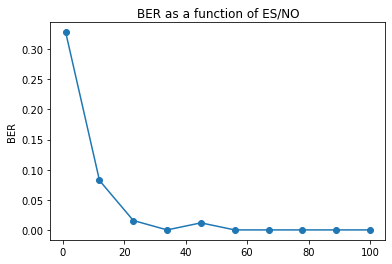

In [9]:
varss= np.linspace(1,100,10)
#def bersnr(K, CP, P, bps, var):


#Applique la fonction bervar à chaque element de varss
BERS = np.array(list(map(lambda x:bervar(128, 4, 2, x/10), varss)))

plt.plot((varss),BERS, '-o')
plt.title("BER as a function of ES/NO")
plt.xlabel("")

plt.ylabel("BER")
plt.show()


In [11]:

from numpy import sqrt
from numpy.random import rand, randn
import numpy as np

esno = np.arange(0,16)
results =[]

n_cyc=16
n_fft=128
n_sym=10000
n_bits=n_fft*n_sym

for i in esno: 

    n_tap=10
    Eb=1.0
    EbNodB=i
    EbNo=10**(EbNodB/10.0)

    s_in=2*(rand(n_bits)>=0.5)-1
    s_est=np.zeros(n_bits)



    for n in range (0, n_sym):
        s_ofdm=sqrt(n_fft)*np.fft.ifft(s_in[n*n_fft:(n+1)*n_fft])
        s_ofdm_cyc=np.concatenate((s_ofdm[n_fft-n_cyc:n_fft], s_ofdm), axis=0)
        
        r_ofdm=s_ofdm_cyc
        r_ofdm_cyc=(r_ofdm[0:n_fft+n_cyc])
        wn=randn(n_fft+n_cyc)+1j*randn(n_fft+n_cyc)
        r_ofdm_cyc=r_ofdm_cyc+sqrt(Eb/(2*EbNo))*wn
        r_ofdm_cropped=r_ofdm_cyc[n_cyc:n_fft+n_cyc]
        s_est[n*n_fft:(n+1)*n_fft]=(1/sqrt(n_fft))*np.real((np.fft.fft(r_ofdm_cropped))/Hf)
    
    s_out=2*(s_est>=0)-1  
    errors=(s_in!=s_out).sum()
    ber=1.0*errors/n_bits

    print('Total number of OFDM symbols', n_sym)
    print('Total number of bits', n_bits)
    print('Total number of bits in error', errors)
    print('Energy per bit to noise PSD(dB)', EbNodB)
    print('Bit Error Rate', ber)
    print()
    results.append(ber)


NameError: name 'Hf' is not defined

In [ ]:
plt.plot(esno,results)
plt.yscale('log')